<h1>How to fit a straight line in Python using Stan</h1>

<h3>Importing things we will need</h3>

In [2]:
import numpy as np               # numpy to deal with arrays and vectorise stuff
import matplotlib.pyplot as plt  # matplotlib for plotting
import pystan                    # pystan is the interface between Python and Stan
import stan_utility              # read in the utility file to handle Stan models
import pickle                    # pickle saves files for re-use later
import corner                    # makes corner plots of distributions
#plt.style.use('thomas')

<h3>Goal:<br>
    Given a data set of $x$ and $y$ values with uncertainties $y_{err}$,<br>
    find the parameters $a$ and $b$ that describe the data through the model<br>
    of the form $f(x) = a + b \cdot x$.</h3>

<h3>Step 1:<br>
    Create data</h3>

<h5>True parameters</h5>

In [3]:
a = 1 # y-intercept
b = 1 # slope

<h5>Create a number $N_{obs}$ of $x$-values of data set, $x_i$, where $i=0 \dots N_{obs}-1$</h5>

In [4]:
N_obs = 10                      # number of data points
x     = np.linspace(0,10,N_obs) # N_obs x-values between 0 and 10, equally spaced

<h5>True data points, $y_i = f(x_i) = a + b \cdot x_i$</h5

In [5]:
y     = a + b*x

<h5>Each $y_i$ is obscured by the measurement process, i.e. introduces an 'uncertainty' $\sigma_i$ such that<br>
    $\tilde{y}_i \sim \mathrm{normal(y_i,\sigma_i)}$,<br>
    meaning, each data point $y_i$ is - through the measurement process - observed as $\tilde{y}_i$,<br>
    which defines our data points as scattered normally around $y_i$ with width $\sigma_i$.</h5>

In [6]:
sigma_value = 5.                     # in this example, all data points have the same uncertainty
sigma = np.repeat(sigma_value,N_obs) # each sigma_i is sigma_value

<h5>Our data set is then:</h5>

In [7]:
yp = y + np.random.randn(N_obs)*sigma
# the np.random.randn() function creates standard-normal-distributed random numbers

<h3>Step 2:<br>
    Plot the data</h3>

<h5>Plotting our info so far:</h5>

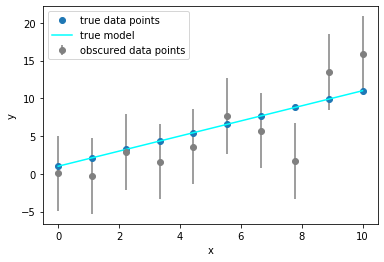

In [8]:
plt.plot(x,y,'o',label='true data points')
plt.errorbar(x,yp,yerr=sigma,marker='o',color='gray',linestyle='',label='obscured data points')
plt.plot(x,y,'-',color='cyan',label='true model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

<h5>Possible data sets, given the random character of our data generation:</h5>

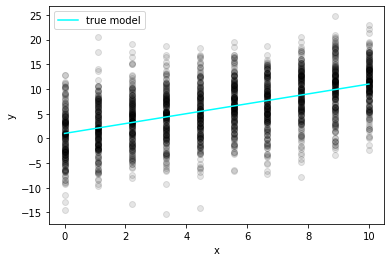

In [9]:
for i in range(200):
    ytmp = y + np.random.randn(N_obs)*sigma
    plt.plot(x,ytmp,'o',color='black',alpha=0.1)
plt.plot(x,y,'-',color='cyan',label='true model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

<h3>Now, the likelihood, $\mathscr{L}(D|M)$, comes into play, defining how probable it is to measure a data point $y_i$ (under its associated uncertainty $\sigma_i$), given the model $f(x_i;a,b)$:<br>
    $\mathscr{L}(D|M) = \mathscr{L}(a,b) = \prod_{i=0}^{N_{obs}-1} \frac{1}{\sqrt{2\pi}\sigma_i}\exp\left(-\frac{(y_i - f(x_i;a,b))^2}{2\sigma_i^2}\right)$<br>
    This is the likelihood for normally distributed data ($\chi^2$-case).</h3>

<h3>Each parameter in a model can (and should) have a prior associated with it.<br>
    This can come from previous knowledge (earlier measurements), knowing the scale of the problem ('look at the data'), and certainly must include domain expertise (knowing what the parameters actually mean).<br>
    It can also be set to define physical limitations of parameters (a quantity must be zero or larger, nothing is faster than the speed of light, etc.).<br>
    In the Stan model fit_straight_line.stan, priors on $a$ and $b$ are defined as Gaussians (normal distributions), such that<br>
    $P(a) = \frac{1}{\sqrt{2\pi}\sigma_a}\exp\left(-\frac{(\mu_a - a)^2}{2\sigma_a^2}\right)$ and <br>
    $P(b) = \frac{1}{\sqrt{2\pi}\sigma_b}\exp\left(-\frac{(\mu_b - b)^2}{2\sigma_b^2}\right)$, with<br>
    our belief in $a$ to be distributed around a value $\mu_a$ with width $\sigma_a$, and $b$ around $\mu_b$ with width $\sigma_b$.</h3>

<h3>Finally, Bayes' law (conditional probability) tells us, how to put these things together:<br>
    $P(M|D) = \frac{P(D|M)P(M)}{P(D)}$, from which we can identify our distributions, an write<br>
    $\pi(a,b) \propto \mathscr{L}(a,b)P(a)P(b)$, where the priors for $a$ and $b$ are taken independently, $P(D)$ is a factor only depending on the data (not on the model parameters $a$ and $b$; called 'evidence'), normalising the probability density function of interest $\pi(a,b)$, which is call the joint posterior probability or $a$ and $b$.</h3>

<h5>1D example for visualisation of what is happening:<br>
    Suppose we have one data point $(x,y,\sigma) = (0,1,1)$, and want to fit a model of the form $f(x) = c$ to that data point. Intuitively, it is clear that $c$ should be exqual to $1 \pm 1$ since $y \pm \sigma = 1 \pm 1$. However, the prior can influence the result.<br>
    Suppose further, 'somebody' told us that $c$ should be more like $5$ and that this somebody is certain by 40%, so that $\mu_a \pm \sigma_a = 5 \pm 2$.<br>
    In summary, our likehood and prior are:<br>
    $\mathscr{L}(c) = \frac{1}{\sqrt{2\pi}}\exp\left(-\frac{(1-c)^2}{2}\right)$ and $P(c) = \frac{1}{2\sqrt{2\pi}}\exp\left(-\frac{(5-c)^2}{8}\right)$.<br>
    Using Bayes' rule, we find<br>
    $\pi(c) \propto \exp\left(\frac{(c-1.8)^2}{2\sqrt{0.8}^2}\right)$ (you should check if you can calculate the same values), so that our posterior distribution of a is again Gaussian with a mean of $\tilde{\mu}_a = 1.8$ and width $\tilde{\sigma}_a = \sqrt{0.8} \approx 0.9$.</h5>

<h5>Let's visualise this in the space of our parameter $c$, by drawing the distributions:</h5>

In [10]:
c = np.linspace(-5,15,1001) # 1001 values of c between -5 and 15 to draw our distributions on

mu_c = 5     # as defined above
sigma_c = 2  # as defined above

# calculate prior
prior_c = 1/(np.sqrt(2*np.pi)*sigma_c)*np.exp(-(c-mu_c)**2 / (2*sigma_c**2))

# calculate likelihood
likelihood_c = 1/(np.sqrt(2*np.pi))*np.exp(-(c-1)**2 / (2))

# calculate posterior (proportional term)
posterior_c = likelihood_c*prior_c # yes, in fact, that's all

# normalise posterior by 'integrating' it 
delta_c = c[1]-c[0] # our c-array is regular, so we only need one step size in c
norm = np.sum(posterior_c*delta_c)
posterior_c /= norm

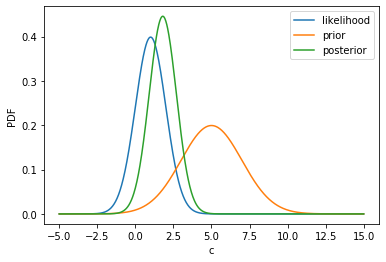

In [11]:
plt.plot(c,likelihood_c,label='likelihood')
plt.plot(c,prior_c,label='prior')
plt.plot(c,posterior_c,label='posterior')
plt.xlabel('c')
plt.ylabel('PDF')
plt.legend()

<h5>We see:<br>
    Our data is dominating the posterior, even though the belief of 'somebody' was very far off.<br>
    Still, the value of $c$ has increased from our expected $1$ to $1.8$ (peak of the blue line).<br>
    We also note that the posterior of $a$ is narrower (higher) than the likelihood alone. This is because even though the prior was apparently a 'bad' guess, the widths of both are propagated towards a joint assessment of data (likelihood) and belief/knowledge/physics/scale/... (prior).<br>
    Finally, to convince ourselves that the calculation is correct, find the maximum of the blue line as:</h5>

In [12]:
c[np.argmax(posterior_c)] # should be close to 1.8

1.7999999999999998

<h5>And the width:</h5>

In [31]:
1/np.max(posterior_c)/np.sqrt(2*np.pi),(1/np.max(posterior_c)/np.sqrt(2*np.pi))**2 # should be close to 0.9, 0.8

(0.8944271909998851, 0.799999999999945)

<h3>Step 3:<br>
    Define a model</h3>

<h3>Now, as you can guess, with more data points, more parameters, and different distributions, such a calculation is very hard to do by hand. This is why we use Stan.</h3><br>
    <h5>We compile our model using the pystan interface as:</h5>

In [ ]:
## compile model (if not yet compiled):
model = pystan.StanModel('fit_straight_line.stan')

<h5>For later use, we save the compiled model to a .pkl file using the pickle package:</h5>

In [ ]:
## save it to the file 'filename.pkl' for later use
with open('fit_straight_line_wpriors.pkl', 'wb') as f:
    pickle.dump(model, f)

<h5>Finally, if you already did the first two steps, you don't need to compile again every time you want to use the model, but rather load it with pickle again (i.e. you can comment out the first two steps):</h5>

In [14]:
#read filename.pkl (if already compiled)
model = pickle.load(open('fit_straight_line_wpriors.pkl', 'rb'))

<h5>The Stan model looks like this:</h5>

In [15]:
print(model.show())

StanModel object 'anon_model_36049ae168e31e4fd2ca1c91a5951697' coded as follows:
data {

  int<lower=0> N; // number of data points
  vector[N] x; // x observations
  vector[N] y; // y observations  
  vector[N] y_err; // y observation uncertainty

  int<lower=0> N_model; // number of data points for line
  vector[N_model] x_model; //where to evaluate the model
  
  //priors on the fitted parameters
  real mu_a;
  real sigma_a;
  real mu_b;
  real sigma_b;
  
}

parameters {
  
  real a; //intercept of straight line
  real b; //slop of straight line

}

model {

  // weakly informative priors
// no priors at the moment
  a ~ normal(mu_a,sigma_a);
  b ~ normal(mu_b,sigma_b);

  // likelihood

  y ~ normal(a+b*x, y_err);

  

}

generated quantities {

  vector[N] ppc;
  vector[N_model] straight_line;

  // generate the posterior of the
  // fitted straight line
  straight_line = a + b * x_model;

  // create posterior samples for PPC
  for (n in 1:N) {
    
    ppc[n] = normal_rng(a + b

<h5>Here, the data block is what is provided to Stan through a python dictionary (see below).<br>
    We also require the prior means and widths for $a$ and $b$, which we just set to the scale of our problem:<br>
    (You should play around with these values to see, what is going on with the fit, when changing these numbers.)</h5>

In [16]:
# Gaussian priors on a and b
mu_a = 10
sigma_a = 10
mu_b = 10
sigma_b = 10

<h5>Following the data block, we also need the variables $N_{model}$ and $x_{model}$, which is the number of data points and where we want to evaluate our fitted model. These are the points where we want to make a 'prediction', given the data, its uncertainties, the model definition, and the priors of the model parameters.</h5>

In [17]:
# where to evaluate the model
N_model = 100                            # 100 values between
x_model = np.linspace(-2.5,12.5,N_model) # -2.5 and 12.5, equally spaced

<h5>Finally, our data block is given by the following dictionary:</h5>

In [18]:
# dictionary for data set and prior
data = dict(N = N_obs,
            x = x,
            y = yp,
            y_err = sigma,
            N_model = N_model,
            x_model = x_model,
            mu_a = mu_a,
            sigma_a = sigma_a,
            mu_b = mu_b,
            sigma_b = sigma_b)

<h3>Step 4:<br>
    Fit the data</h3>

<h5>And then, fit:</h5>

In [19]:
# fit the model
fit = model.sampling(data=data,chains=1,iter=10000)

<h5>First, we look at our interesting parameters $a$ and $b$ that we got from the fit:</h5>

In [20]:
print(fit.stansummary(['a','b']))

Inference for Stan model: anon_model_36049ae168e31e4fd2ca1c91a5951697.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a  -1.52    0.08   2.81  -7.07  -3.38  -1.51   0.32   3.95   1394    1.0
b   1.22    0.01   0.48   0.29    0.9   1.23   1.55   2.16   1337    1.0

Samples were drawn using NUTS at Fri Jul  3 22:50:58 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


<h5>Here, we see the mean an std of $a$ and $b$ which we can quote as the results of our fits, and would be done.<br>
    However, we have to assess the fit itself, for which we extract the different samples, look at their distributions, visualise our model, and make predictions.</h5>

<h5>First, a plot of the marginalised posterior distributions of $a$ and $b$, i.e.<br>
   $\pi(a) = \int_{-\infty}^{+\infty} db\,\pi(a,b)$ and $\pi(b) = \int_{-\infty}^{+\infty} da\,\pi(a,b)$

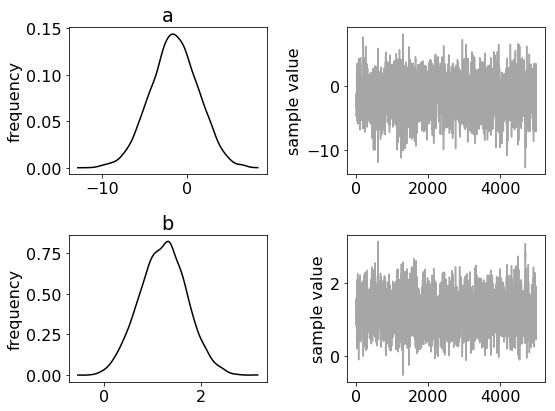

In [21]:
fit.plot(['a','b'],)
plt.tight_layout()

<h5>Here, we see how the samples are drawn on the right, and what the histogrammed density distribution for $a$ and $b$ look like in our fit. A bad fit would show jumps in the samples or the distributions to push against a boundary. The fit in this case here should (always) be okay.</h5>

<h5>Extract the parameter chains and other generated quantities from the fitted Stan model:</h5>

In [22]:
# extract information
chain = fit.extract()

In [23]:
chain.keys() # what's inside:
# distributions of a and b and the generated quantities from the Stan model

odict_keys(['a', 'b', 'ppc', 'straight_line', 'lp__'])

<h3>Step 5:<br>
    Assess the fit quality</h3>

<h5>Now, we plot the model prediction on top of our data points, and compare the fit visually:</h5>

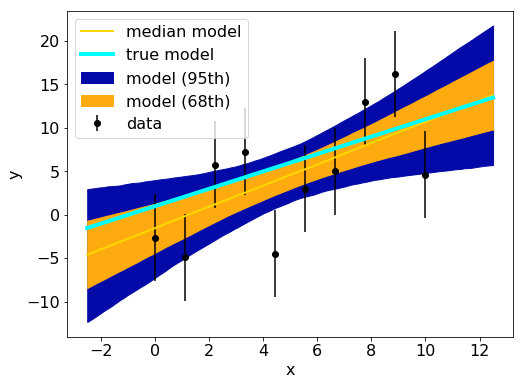

In [24]:
plt.errorbar(x,yp,yerr=sigma,marker='o',linestyle='',color='black',label='data')

level = 95.4
plt.fill_between(x_model,
                np.percentile(chain['straight_line'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['straight_line'], 50 + 0.5*level, axis=0 ),
                color='xkcd:cobalt blue',alpha=1.0,label='model (95th)')

level = 68.3
plt.fill_between(x_model,
                np.percentile(chain['straight_line'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['straight_line'], 50 + 0.5*level, axis=0 ),
                color='xkcd:yellowish orange',alpha=1,label='model (68th)')

fit_model = np.median(chain['straight_line'],axis=0)
plt.plot(x_model,fit_model,linewidth=2,color='gold',label='median model')
    
plt.xlabel('x')
plt.ylabel('y')

plt.plot(x_model,a+x_model*b,color='cyan',linewidth=4,label='true model')

plt.legend()

<h5>The cyan line of our true model (input which we defined to create the data in the first place), should be within the blue band most of the time.<br>
    We see that the model gets more uncertain when we go beyond our first and last data points, which is clear as nothing constrains the fit there.</h5>

<h5>Alternative, we can also plot individual realisations of our posterior model to see underlying structure (if any; not here):</h5>

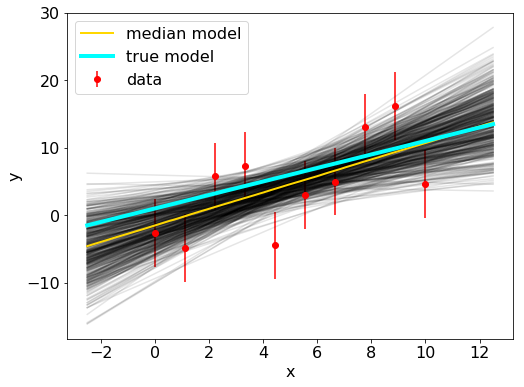

In [25]:
plt.errorbar(x,yp,yerr=sigma,marker='o',color='red',linestyle='',label='data')
for i in range(0,5000,10):
    plt.plot(x_model,chain['straight_line'][i,:],alpha=0.1,color='black')
plt.plot(x_model,fit_model,linewidth=2,color='gold',label='median model')
plt.xlabel('x')
plt.ylabel('y')

plt.plot(x_model,a+x_model*b,color='cyan',linewidth=4,label='true model')

plt.legend()

<h5>As we see in this example, $a$ and $b$ appear anti-correlated: we should also see this in the join posterior distribution $pi(a,b)$ from plotting it in a corner (or triangle) plot:</h5>

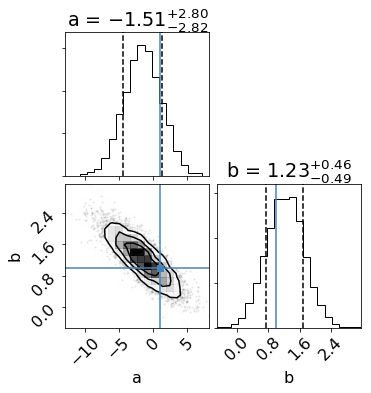

In [26]:
corner.corner(np.array([chain['a'],chain['b']]).T,
              labels=['a','b'],
              quantiles=[0.5-0.683/2,0.5+0.683/2],
              show_titles=True,
              truths=[a,b]);

<h5>We see that the larger $a$, the small (more negative) $b$ should get, and vice versa. This is in the nature of the model, and how the data are actually structured.</h5>

<h5>Finally, we want to know, how good our model would be in predicting new data, i.e. did we find the (or a) good model description that does not only describe the current data set, but also captures the (true) data generating process.<br>
    For this, we perform posterior predictive checks (PPC), that is sampling 'new data' $\hat{y}$ from our posterior distribution $\pi(a,b|y)$, given our measurement principle, which is incorporated in the likelihood $\mathscr{L}(\hat{y}|a,b)$, such that<br>
    $\pi(\hat{y}|y) = \int \int da\,db\,\mathscr{L}(\hat{y}|a,b) \pi(a,b|y)$.<br>
    (Note that, if you already had quantum mechanics, how this can be interpreted in other terms; cf. Dirac Bra-Ket notation.)</h5>

<h5>Here, you should also notice that 'integration' and 'sampling' are somewhat synonymous, as such an integration can be hard to calculate in general terms to get the wanted distribution, for which reason, it is approximated by sampling points, and rejecting those which do not fall inside the distribution (cf. again, 'Monte Carlo integration').</h5>

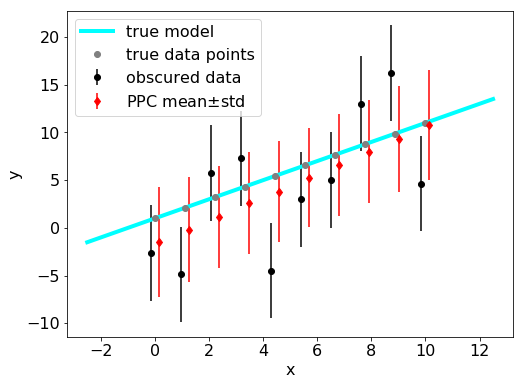

In [27]:
# ppc plot

plt.errorbar(x-0.15,yp,yerr=sigma,marker='o',linestyle='',color='black',label='obscured data')

plt.errorbar(x+0.15,np.mean(chain['ppc'],axis=0),yerr=np.std(chain['ppc'],axis=0),
             color='red',marker='d',linestyle='',label=r'PPC mean$\pm$std')

plt.plot(x_model,a+x_model*b,color='cyan',linewidth=4,label='true model')

plt.plot(x+0.0,y,'o',color='gray',label='true data points')

plt.xlabel('x')
plt.ylabel('y')

plt.legend()

<h5>Crowded plot:<br>
    The true data points are not available to a general data set case, so I just plot them for comparison.<br>
    We do see that the red (replicated) data points do capture the data generating process, even though there seems to be a different trend. Depending on the actual data set realisation, note that the 'error bars' of the replicated data are larger than the those of the obscured (measured) data points themselves. That means, the range of possible data points in a renewed measurement, if our inference was correct, can actually larger than what we see. This makes sense, because PPCs use both the likelihood and posterior information, and takes all(!) values of $a$ and $b$ into account.</h5>

In [28]:
np.std(chain['ppc'],axis=0)

array([5.73997731, 5.49891601, 5.33654659, 5.36242847, 5.2826181 ,
       5.22969617, 5.32319498, 5.40005697, 5.53207631, 5.76851061])

<h5>As a last step, we visualise the 'ppc residuals', i.e. data minus generated data, versus the uncertainty from that generated data. If we fitted a correct model and capture all details in the data set with our used model (if any), there should be no outliers 'far' from zero. In the following plot, the red points should be within the 99% percentile for us to claim an adequate fit.</h5>

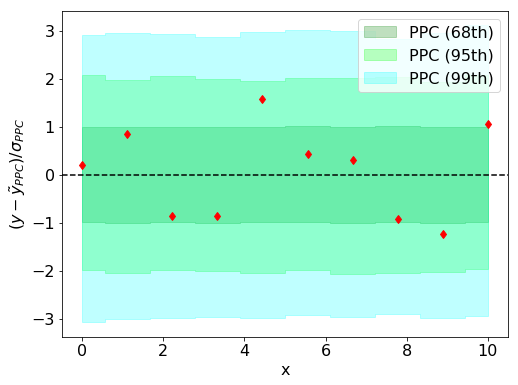

In [29]:
# ppc points 

plt.plot(x,(np.mean(chain['ppc'],axis=0)-yp)/np.std(chain['ppc'],axis=0),
             color='red',marker='d',linestyle='')

plt.fill_between(x,
                 np.nan_to_num((np.percentile(chain['ppc'],50+68.3/2,axis=0)-np.mean(chain['ppc'],axis=0))/np.std(chain['ppc'],axis=0)),
                 np.nan_to_num((np.percentile(chain['ppc'],50-68.3/2,axis=0)-np.mean(chain['ppc'],axis=0))/np.std(chain['ppc'],axis=0)),
                 color='green',step='mid',alpha=0.25,label='PPC (68th)')

plt.fill_between(x,
                 np.nan_to_num((np.percentile(chain['ppc'],50+95.4/2,axis=0)-np.mean(chain['ppc'],axis=0))/np.std(chain['ppc'],axis=0)),
                 np.nan_to_num((np.percentile(chain['ppc'],50-95.4/2,axis=0)-np.mean(chain['ppc'],axis=0))/np.std(chain['ppc'],axis=0)),
                 color='lime',step='mid',alpha=0.25,label='PPC (95th)')

plt.fill_between(x,
                 np.nan_to_num((np.percentile(chain['ppc'],50+99.7/2,axis=0)-np.mean(chain['ppc'],axis=0))/np.std(chain['ppc'],axis=0)),
                 np.nan_to_num((np.percentile(chain['ppc'],50-99.7/2,axis=0)-np.mean(chain['ppc'],axis=0))/np.std(chain['ppc'],axis=0)),
                 color='cyan',step='mid',alpha=0.25,label='PPC (99th)')

plt.axhline(0,linestyle='--')
    
plt.xlabel('x')
plt.ylabel(r'$(y-\tilde{y}_{PPC})/\sigma_{PPC}$')

plt.legend()

<h5>Note that the sampled bands are symmetric around $0$ with a standard deviation of $1$, as would be expected from a standard normal distribution.<br>
    In the case of other distributions (e.g. Poisson for counting experiments), these residuals are going to be assymetric.</h5>

<h3>Step 6:<br>
    House.</h3>

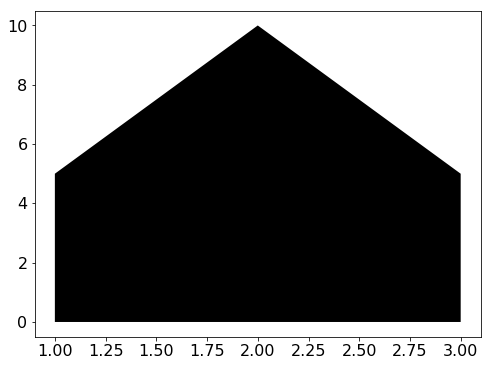

In [30]:
plt.fill_between([1,2,3],
                 [0,0,0],
                 [5,10,5])